In [1]:
import tensorflow as tf
import os
import numpy as np
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
import time

from skimage.io import imread, imshow
from sklearn.metrics import  f1_score, precision_score, recall_score, jaccard_score

### Metrics functions

In [3]:
def dice_coef(y_true, y_pred, smooth=1):
    # Ensure the tensors are of type float32
    y_true_f = K.cast(K.flatten(y_true), 'float32')
    y_pred_f = K.cast(K.flatten(y_pred), 'float32')
    
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * dice_loss(tf.cast(y_true, tf.float32), y_pred)


### Data Preprocessing

In [ ]:
# Params
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [ ]:
TRAIN_PATH = 'data_mod/train/'
TEST_PATH = 'data_mod/test/'

def delete_blank_masks(path):
    for mask in tqdm(os.listdir(path + 'labels/')):
        mask_path = path + 'labels/' + mask
        mask = imread(mask_path)
        if np.sum(mask) == 0:
            print('Deleting', mask_path)
            print(mask_path.split('/')[-1])
            os.remove(mask_path)
            os.remove(path + 'images/' + mask_path.split('/')[-1])


def resize(input_image, input_mask):
    input_image = tf.image.resize(input_image, (IMG_WIDTH, IMG_HEIGHT), method="nearest")
    input_mask = tf.image.resize(input_mask, (IMG_WIDTH, IMG_HEIGHT), method="nearest")
    # Convert mask to grayscale
    input_mask = tf.image.rgb_to_grayscale(input_mask)

    return input_image, input_mask 

def augment(input_image, input_mask):
    is_flip = False
    if tf.random.uniform(()) > 0.5:
        # Random flipping of the image and mask
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
        is_flip = True

    # if tf.random.uniform(()) > 0.5:
    #     # Random flipping of the image and mask
    #     input_image = tf.image.flip_up_down(input_image)
    #     input_mask = tf.image.flip_up_down(input_mask)
    #     is_flip = True

    # if tf.random.uniform(()) > 0.5:
    #     # Random rotation of the image and mask
    #     input_image = tf.image.random_brightness(input_image, 0.2)
    #     is_flip = True

    # if tf.random.uniform(()) > 0.5:
    #     # Random rotation of the image and mask
    #     input_image = tf.image.random_contrast(input_image, 0.7, 1.3)
    #     is_flip = True

    return input_image, input_mask, is_flip

def normalize(input_image):
    input_image = tf.cast(input_image, tf.float32)
    input_image = input_image / 255.0
    return input_image

In [6]:
X_train = []
Y_train = []
# X_test = []

# Conta a quantidade de imagens de test
# n_test = len(os.listdir(TEST_PATH+'images'))
n_train = len(os.listdir(TRAIN_PATH+'images'))


# X_train = np.zeros((n_train, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
# Y_train = np.zeros((n_train, IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
# X_test = np.zeros((n_test, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)


# # Load test images
# for i in tqdm(range(n_test)):
#     img = imread(TEST_PATH+'images/'+os.listdir(TEST_PATH+'images')[i])[:,:,:IMG_CHANNELS]
#     img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
#     img = tf.image.flip_left_right(img)
#     X_test[i] = img

# Load train images
for i in tqdm(range(n_train)):
    # Carrega a imagem e a máscara
    img = imread(TRAIN_PATH+'images/'+os.listdir(TRAIN_PATH+'images')[i])[:,:,:IMG_CHANNELS]
    mask = imread(TRAIN_PATH+'labels/'+os.listdir(TRAIN_PATH+'labels')[i])
    img, mask = resize(img, mask)
    # Printa o tipo da máscara
    img = normalize(img)
    X_train.append(img)
    Y_train.append(mask)
    
    # Faz a augmentação e adiciona a imagem flipada, se houver
    img, mask, is_flip = augment(img, mask)
    if is_flip:
        X_train.append(img)
        Y_train.append(mask)

# Converter listas para arrays NumPy
X_train = np.array(X_train, dtype=np.float32)
Y_train = np.array(Y_train, dtype=bool)

  5%|▍         | 38/791 [00:03<01:04, 11.75it/s]


KeyboardInterrupt: 

In [35]:
# Delete all blank masks
# delete_blank_masks(TRAIN_PATH)
print(X_train.shape)
print(Y_train.shape)

(1196, 128, 128, 3)
(1196, 128, 128, 1)


### Model - Modified UNet


In [16]:
def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    
    return x

In [17]:
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = tf.keras.layers.MaxPool2D(2)(f)
    p = tf.keras.layers.Dropout(0.3)(p)

    return f, p

In [18]:
def upsample_block(x, conv_features, n_filters):
    # upsample
    x = tf.keras.layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate 
    x = tf.keras.layers.concatenate([x, conv_features])
    # dropout
    x = tf.keras.layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x

In [19]:
def build_unet_model():
    # Input layer
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs) # Normalizing the inputs

    initial_filters = 16

    # Encoder
    c1, p1 = downsample_block(s, initial_filters)
    c2, p2 = downsample_block(p1, initial_filters*2)
    c3, p3 = downsample_block(p2, initial_filters*4)
    c4, p4 = downsample_block(p3, initial_filters*8)

    # Bottleneck
    bn = double_conv_block(p4, initial_filters*16)

    # Decoder
    u6 = upsample_block(bn, c4, initial_filters*8)
    u7 = upsample_block(u6, c3, initial_filters*4)
    u8 = upsample_block(u7, c2, initial_filters*2)
    u9 = upsample_block(u8, c1, initial_filters)

    # Output layer
    outputs = tf.keras.layers.Conv2D(1, 1, activation="sigmoid")(u9)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

In [66]:
model = build_unet_model()
# Params
BATCH_SIZE=32
EPOCHS=100

# model.summary()
# model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[tf.keras.metrics.MeanIoU(num_classes=2), tf.keras.metrics.CategoricalAccuracy()])
model.compile(tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9, nesterov=True), loss=dice_coef, metrics=[dice_coef, tf.keras.metrics.MeanIoU(num_classes=2)])

### Fitting


In [67]:
# training date - take the today's date
import datetime
today = datetime.date.today()
today = today.strftime("%Y-%m-%d")

#Checkpoint
file_path = "models/" + today + "_model.keras"
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=file_path, save_best_only=True, verbose=1)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=15, monitor="val_loss"),
    tf.keras.callbacks.TensorBoard(log_dir="logs"),
    checkpointer
]

# Train the model
results = model.fit(X_train, Y_train, validation_split=0.3, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/100
 5/27 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - dice_coef: 0.0246 - loss: 0.0246 - mean_io_u_6: 0.4937

KeyboardInterrupt: 

### Plot the training results

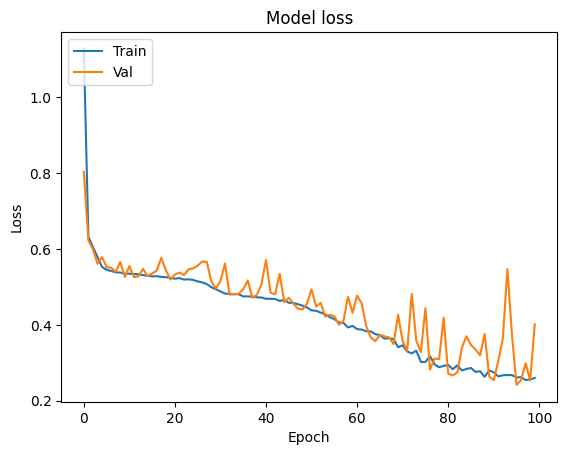

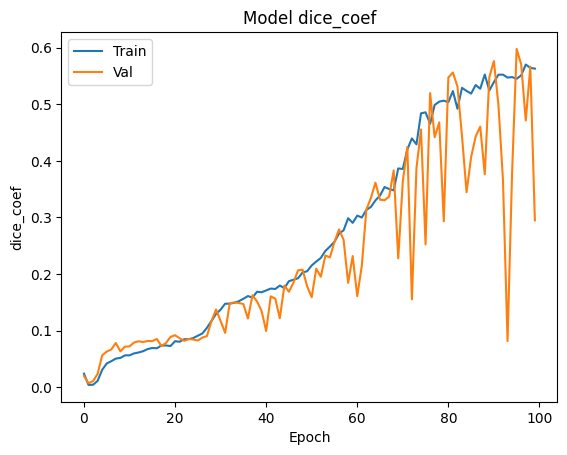

In [58]:
#Plot the training and validation loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

#Plot the training and validation dice_coef
plt.plot(results.history['dice_coef'])
plt.plot(results.history['val_dice_coef'])
plt.title('Model dice_coef')
plt.ylabel('dice_coef')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

### Predictions

In [21]:
# #carrega o modelo
model = tf.keras.models.load_model('models/2024-10-26_model.keras', custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_coef': dice_coef}, safe_mode=False)

In [25]:
# Val data
VAL_PATH = 'data_mod/validation/'

n_val = len(os.listdir(VAL_PATH+'images'))

X_val = []
Y_val = []

# Load val images
# Load train images
for i in tqdm(range(n_val)):
    # Carrega a imagem e a máscara
    img = imread(VAL_PATH+'images/'+os.listdir(VAL_PATH+'images')[i])[:,:,:IMG_CHANNELS]
    mask = imread(VAL_PATH+'labels/'+os.listdir(VAL_PATH+'labels')[i])
    img, mask = resize(img, mask)
    img = normalize(img)
    X_val.append(img)
    Y_val.append(mask)
    
    # Faz a augmentação e adiciona a imagem flipada, se houver
    # img, mask, is_flip = augment(img, mask)
    # if is_flip:
    #     X_val.append(img)
    #     Y_val.append(mask)

# Converter listas para arrays NumPy
X_val = np.array(X_val, dtype=np.float32)
Y_val = np.array(Y_val, dtype=bool)

100%|██████████| 195/195 [00:03<00:00, 49.97it/s]


In [28]:
print(X_val.shape)
print(Y_val.shape)

(195, 128, 128, 3)
(195, 128, 128, 1)


In [22]:
# Predict on val, train and test
preds_val = model.predict(X_val, verbose=1)
# preds_train = model.predict(X_train, verbose=1)
# preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_val_t = (preds_val > 0.3).astype(np.uint8)
# preds_train_t = (preds_train > 0.3).astype(np.uint8)
# preds_test_t = (preds_test > 0.3).astype(np.uint8)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 346ms/step


### Evaluate

In [23]:
# Função que calcula o Dice Coefficient
# np.sum(mask1 * mask2) calcula o número de elementos em comum entre as duas máscaras mask1 e mask2. Como as máscaras são binárias (0 ou 1), a multiplicação de
# mask1 por mask2 resulta em 1 apenas onde ambos têm valor 1, e em 0 onde qualquer um tem valor 0. A soma (np.sum) desses produtos dá a quantidade de pixels que são 1 em
# ambas as máscaras, ou seja, a interseção entre elas.
# np.sum(mask1) e np.sum(mask2) calculam a quantidade de pixels que são 1 em cada uma das máscaras, ou seja, a soma de todos os pixels de cada máscara.
def DICE_COE(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    fsum = np.sum(mask1)
    ssum = np.sum(mask2)
    union = fsum + ssum
    if(union == 0):
        return 0
    dice = (2 * intersect ) / (union)
    return dice    

dice_values = []
for ix in range(len(X_val)):
    dice_values.append([ix, dice_coef(preds_val_t[ix].flatten(), Y_val[ix].flatten())])

jaccard_values = []
for ix in range(len(X_val)):
    jaccard_values.append([ix, jaccard_score(Y_val[ix].flatten(), preds_val_t[ix].flatten(), zero_division=0)])

f1_values = []
for ix in range(len(X_val)):
    f1_values.append([ix, f1_score(Y_val[ix].flatten(), preds_val_t[ix].flatten(), zero_division=0)])


recall_values = []
for ix in range(len(X_val)):
    recall_values.append([ix, recall_score(Y_val[ix].flatten(), preds_val_t[ix].flatten(), zero_division=0)])

precision_values = []
for ix in range(len(X_val)):
    precision_values.append([ix, precision_score(Y_val[ix].flatten(), preds_val_t[ix].flatten(), zero_division=0)])

print("Dice Score: ", np.mean(dice_values, axis=0)[1])
print("Jaccard/IoU Score: ", np.mean(jaccard_values, axis=0)[1])
print("F1 Score: ", np.mean(f1_values, axis=0)[1])
print("Recall Score: ", np.mean(recall_values, axis=0)[1])
print("Precision Score: ", np.mean(precision_values, axis=0)[1])


Dice Score:  0.0026307993156548877
Jaccard/IoU Score:  3.611412062116287e-05
F1 Score:  7.172314864622557e-05
Recall Score:  4.371871379544014e-05
Precision Score:  0.00019954105557218397


### TinyML

In [16]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\joaod\AppData\Local\Temp\tmp49jwbibr\assets


INFO:tensorflow:Assets written to: C:\Users\joaod\AppData\Local\Temp\tmp49jwbibr\assets


Saved artifact at 'C:\Users\joaod\AppData\Local\Temp\tmp49jwbibr'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None)
Captures:
  2110418534224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2110460478672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2110460477520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2110460482512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2110460483472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2110460480592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2110460481936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2110460481552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2110460479632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2110460480784: TensorSpec(shape=(), dtype=tf.resource, name=No

In [17]:
with open('TinyML/tflite', 'wb') as f:
        f.write(tflite_model)

In [19]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_qaware_model = converter.convert()

# %%
with open('TinyML/tflite-reduzido', 'wb') as f:
    f.write(tflite_qaware_model)

INFO:tensorflow:Assets written to: C:\Users\joaod\AppData\Local\Temp\tmp0lbo540f\assets


INFO:tensorflow:Assets written to: C:\Users\joaod\AppData\Local\Temp\tmp0lbo540f\assets


Saved artifact at 'C:\Users\joaod\AppData\Local\Temp\tmp0lbo540f'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None)
Captures:
  2110418534224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2110460478672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2110460477520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2110460482512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2110460483472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2110460480592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2110460481936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2110460481552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2110460479632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2110460480784: TensorSpec(shape=(), dtype=tf.resource, name=No

In [21]:
model_paths = ['TinyML/tflite', 'TinyML/tflite-reduzido']

In [28]:
for model_name in model_paths:
        # Load the TFLite model and allocate tensors.
        interpreter = tf.lite.Interpreter(model_path=model_name)
        interpreter.allocate_tensors()

        # Get input and output tensors.
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()

        # Process each instance
        preds = []
        preds_start_time = time.time()
        for i in tqdm(range(n_train)):
            print(Y_val[i].shape)
            input_tensor = Y_val[i]
            interpreter.set_tensor(input_details[0]['index'], input_tensor)
            interpreter.invoke()
            output_data = interpreter.get_tensor(output_details[0]['index'])
            preds.append(output_data)
        preds_end_time = time.time()
        preds_inference_time = preds_end_time - preds_start_time

print("Inference time: ", preds_inference_time)
print(preds)

  0%|          | 0/791 [00:01<?, ?it/s]

(128, 128, 1)


ValueError: Cannot set tensor: Got value of type BOOL but expected type FLOAT32 for input 0, name: serving_default_input_layer_1:0 

In [ ]:
with open("resultsV2.txt", "a") as file:
    for model_name in model_paths:
        # Load the TFLite model and allocate tensors.
        interpreter = tf.lite.Interpreter(model_path=model_name)
        interpreter.allocate_tensors()

        # Get input and output tensors.
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()

        # Process each instance
        preds = []
        preds_start_time = time.time()
        for i in tqdm(range(n_train)):
            input_tensor = Y_val[i].reshape(input_details[0]['shape'])
            interpreter.set_tensor(input_details[0]['index'], input_tensor)
            interpreter.invoke()
            output_data = interpreter.get_tensor(output_details[0]['index'])
            preds.append(output_data)
        preds_end_time = time.time()
        necrose_inference_time = preds_end_time - preds_start_time

        # Evaluate the model
        
        

        # Obter o tamanho do modelo em MB
        model_size = os.path.getsize(model_name) / (1024 * 1024)

        # Escrever os resultados no arquivo
        file.write(f"Modelo: {model_name}\n")
        file.write(f"Acurácia: {accuracy}\n")
        file.write(f"Tempo de inferência para Necrose: {necrose_inference_time} segundos\n")
        file.write(f"Tempo de inferência para Fibrinose: {fibrinose_inference_time} segundos\n")
        file.write(f"Tamanho do modelo: {model_size} MB\n\n")


### Plot some results

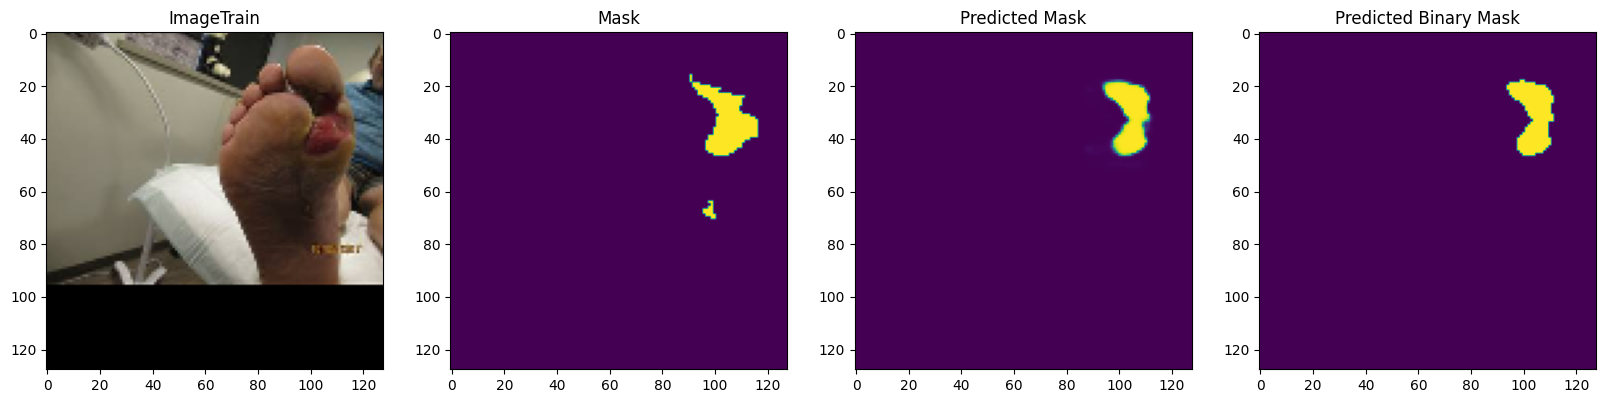

In [11]:
# Plot the results
def plot_sample(title, X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix])
    ax[0].set_title('Image' + title)

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    ax[2].set_title('Predicted Mask')

    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    ax[3].set_title('Predicted Binary Mask')

# Check if training data looks all right
plot_sample("Train", X_val, Y_val, preds_val, preds_val_t )

# Check if valid data looks all right
# plot_sample("Val", X_val, Y_val, preds_val, preds_val_t, ix=130)
# plot_sample("Val", X_val, Y_val, preds_val, preds_val_t, ix=183)
# plot_sample("Val", X_val, Y_val, preds_val, preds_val_t, ix=4)
# plot_sample("Val", X_val, Y_val, preds_val, preds_val_t, ix=133)
# Check if test data looks all right
# Y_test = np.zeros((n_test, IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
# plot_sample("Test", X_test, Y_test, preds_test, preds_test_t)

In [12]:
#115 é para acertar, e 30 é para errar
# Melhores [130, 0.985172981878089], [155, 0.9750271444082519], [135, 0.9725829725829725], [184, 0.9608150470219435], [69, 0.9565217391304348]
# Piores [[4, 0.0], [30, 0.0], [43, 0.0], [53, 0.0], [83, 0.0]]
# Medianos [[13, 0.5228519195612431], [67, 0.5454545454545454], [164, 0.5668449197860963], [65, 0.5703125], [183, 0.573208722741433]]
ix = 0

F1 score: 0.25806451612903225


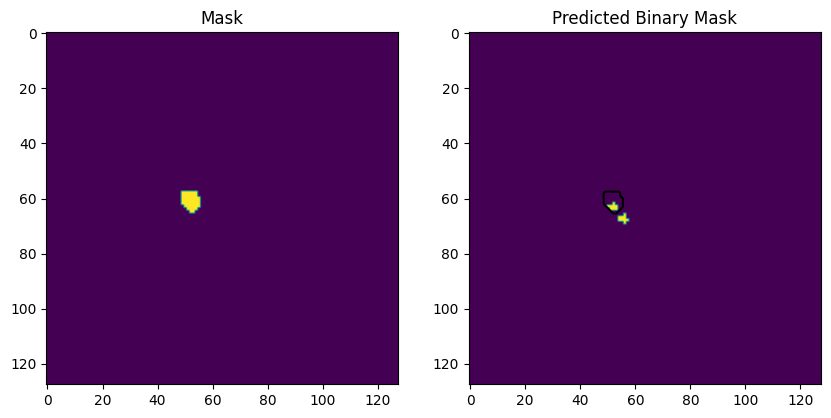

0


In [13]:
f1_value = f1_score(Y_val[ix].flatten(), preds_val_t[ix].flatten())
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(Y_val[ix].squeeze())
ax[1].imshow(preds_val_t[ix].squeeze())
ax[0].set_title('Mask')
ax[1].set_title('Predicted Binary Mask')
ax[1].contour(Y_val[ix].squeeze(), colors='k', levels=[0.5])
print("F1 score:", f1_value)
# Espera o usuário pressionar uma tecla para continuar
plt.show()
# ix= ix + 1
print(ix)

In [14]:
# # Mostra o que teve os top 5 valores de F1
f1_values.sort(key=lambda x: x[1], reverse=True)
print(f1_values[:5])

# # Mostra o que teve os top 5 piores valores de F1
f1_values.sort(key=lambda x: x[1], reverse=False)
print(f1_values[:5])

# # Mostra os top 5 valores medianos de f1
f1_values.sort(key=lambda x: x[1], reverse=False)
print(f1_values[round(len(f1_values)/2)-2:round(len(f1_values)/2)+3])

NameError: name 'f1_values' is not defined